<a href="https://colab.research.google.com/github/NicolasSBellina/LimpandoCodigo/blob/main/Trabalho_pratico_com_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
dir_to_remove = []
dir_to_remove = ['/content/TRAIN', '/content/VAL', '/content/TEST', '/content/CLASSES','/content/BW']
for dir in dir_to_remove:
  if os.path.exists(dir):
    print(f"O diretório '{dir}' existe. Apagando...")
    # Remover o diretório e todo o seu conteúdo
    shutil.rmtree(dir)
    print(f"O diretório '{dir}' foi apagado com sucesso.")
  else:
    print(f"O diretório '{dir}' não existe.")

NameError: name 'os' is not defined

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as ke
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
import seaborn as sns
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras import models
from keras import layers
from keras import optimizers
from keras.applications import DenseNet121

from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping


init_notebook_mode(connected=True)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alfageme/dermatologic-ultrasound-images")
imgs = path + '/images/bw'
csv = pd.read_csv(path + '/201database.csv',header='infer')
csv.columns = csv.columns.str.strip()

#Cria os Diretorios
if not os.path.exists('CLASSES'):
    os.makedirs('CLASSES')
if not os.path.exists('BW'):
    os.makedirs('BW')
if not os.path.exists('DOPPLER'):
    os.makedirs('DOPPLER')

dop = "doppler"

#Transfere as imagens do dataset baixado para seu respectivo diretorio criado
for arquivo in os.listdir(imgs):
    if dop in arquivo:
        shutil.copy(imgs + '/' + arquivo, 'DOPPLER')
    else:
        shutil.copy(imgs + '/' + arquivo, 'BW')
print(csv)

                images_bw              image_doppler       label  \
0     images/bw/01_bw.jpg   images/bw/01_doppler.jpg      BENIGN   
1     images/bw/02_bw.jpg   images/bw/02_doppler.jpg      BENIGN   
2     images/bw/03_bw.jpg   images/bw/03_doppler.jpg      BENIGN   
3     images/bw/04_bw.jpg   images/bw/04_doppler.jpg      BENIGN   
4     images/bw/05_bw.jpg   images/bw/05_doppler.jpg      BENIGN   
..                    ...                        ...         ...   
197  images/bw/198_bw.jpg  images/bw/198_doppler.jpg      BENIGN   
198  images/bw/199_bw.jpg  images/bw/199_doppler.jpg      BENIGN   
199  images/bw/200_bw.jpg  images/bw/200_doppler.jpg   MALIGNANT   
200  images/bw/201_bw.jpg  images/bw/201_doppler.jpg      BENIGN   
201  images/bw/202_bw.jpg  images/bw/202_doppler.jpg      BENIGN   

                        dx                      freq;;;;;;  
0      VENOUS MALFORMATION   lowr;;;;;;VENOUS MALFROMATION  
1                LEIOMIOMA                      lowr;;;;;;  


In [ ]:
bw = '/content/BW'

intervalos_hsv = {
    'vermelho': (np.array([0, 120, 70]), np.array([10, 255, 255])),
    'verde': (np.array([35, 50, 50]), np.array([85, 255, 255])),
    'azul': (np.array([100, 150, 0]), np.array([140, 255, 255])),
    'amarelo': (np.array([20, 100, 100]), np.array([30, 255, 255]))
} # Limite superior do vermelho em HSV

for arquivo in os.listdir(bw):
  img = cv2.imread(bw + '/' + arquivo)

  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  cor_detectada = False

  for cor, (limite_inf, limite_sup) in intervalos_hsv.items():
            # Criar a máscara para a cor especificada
    mascara = cv2.inRange(hsv, limite_inf, limite_sup)

            # Verificar se a máscara possui pixels detectados (i.e., contém a cor)
    if np.any(mascara > 0) and os.path.exists(bw + '/' + arquivo):
      os.remove(bw + '/' + arquivo)
      print(f'Imagem {arquivo} removida.')


Imagem 57_bw.jpg removida.
Imagem 06_bw.jpg removida.
Imagem 108_bw.jpg removida.
Imagem 155_bw.jpg removida.
Imagem 59_bw.jpg removida.
Imagem 74_bw.jpg removida.
Imagem 137_bw.jpg removida.
Imagem 62_bw.jpg removida.
Imagem 120_bw.jpg removida.
Imagem 121_bw.jpg removida.
Imagem 90_bw.jpg removida.


In [ ]:
#Padroniza os nomes das classes no CSV
csv['dx'] = csv['dx'].str.strip()
csv['dx'] = csv['dx'].replace({'SEBORRHEIC KERATOSIS':'SEBK','Schwanoma':'SCHWANOMA','LEIOMIOMA':'LEIOMYOMA','FIBROFOLICULOMA':'FIBROFOLLICULOMA','LEYOMIOMA':'LEIOMYOMA'})
categorias = csv['dx'].unique()
categorias = categorias.tolist()
categorias.sort()
print(categorias)

#Cria um diretorio para cada Classe unica no CSV
for cat in categorias:
  if not os.path.exists('CLASSES/' + cat):
    os.mkdir('CLASSES/' + cat)

['AK', 'ANGIOMA', 'BCC', 'CYST', 'DERMATOFIBROMA', 'FAT NECROSIS', 'FIBROFOLLICULOMA', 'FIBROMA', 'HEMANGIOMA', 'INTRADERMAL NEVUS', 'KA', 'LEIOMYOMA', 'LIPOMA', 'LYMPHOMA', 'MERKEL', 'METASTASIS', 'NEUROFIBROMA', 'OSTEOMA', 'PILOMATRICOMA', 'SCC', 'SCHWANOMA', 'SEBK', 'SK', 'VASCULAR MALFORMATION', 'VENOUS MALFORMATION']


In [ ]:
#Transfere as imagens da pasta BW para a pasta da sua respectiva classe, baseando-se no CSV
for arquivo in os.listdir('/content/BW'):
  csv.loc[csv['images_bw'].str.contains(arquivo), 'dx'].values[0]
  shutil.copy('BW/' + arquivo, 'CLASSES/' + csv.loc[csv['images_bw'].str.contains(arquivo), 'dx'].values[0] + '/' + arquivo)

In [ ]:
diretorio = '/content/CLASSES/'
imagem_tipo = ['.jpg']

def conta_imagens(dir):
    return sum(
        1 for arq in os.listdir(dir)
        if os.path.isfile(os.path.join(dir, arq)) and os.path.splitext(arq)[1].lower() in imagem_tipo
    )

#conta as imagens de cada subdiretório na pasta CLASS
lista_diretorios = [
    (subdir, conta_imagens(os.path.join(diretorio, subdir)))
    for subdir in os.listdir(diretorio)
    if os.path.isdir(os.path.join(diretorio, subdir))
]

# Ordena os diretórios na lista por contagem de imagens (decrescente)
lista_diretorios.sort(key=lambda x: x[1], reverse=True)

# Separa os 10 diretorios com mais imagens
top_10_diretorios = [item[0] for item in lista_diretorios[:10]]

# Remove os diretórios que não estão no top 10
for subdir in os.listdir(diretorio):
    subdir_path = os.path.join(diretorio, subdir)
    if os.path.isdir(subdir_path) and subdir not in top_10_diretorios:
        shutil.rmtree(subdir_path)
        print(f"Removido: {subdir_path}")

Removido: /content/CLASSES/FIBROMA
Removido: /content/CLASSES/VENOUS MALFORMATION
Removido: /content/CLASSES/SK
Removido: /content/CLASSES/FIBROFOLLICULOMA
Removido: /content/CLASSES/KA
Removido: /content/CLASSES/INTRADERMAL NEVUS
Removido: /content/CLASSES/SCHWANOMA
Removido: /content/CLASSES/LYMPHOMA
Removido: /content/CLASSES/VASCULAR MALFORMATION
Removido: /content/CLASSES/FAT NECROSIS
Removido: /content/CLASSES/ANGIOMA
Removido: /content/CLASSES/MERKEL
Removido: /content/CLASSES/HEMANGIOMA
Removido: /content/CLASSES/OSTEOMA
Removido: /content/CLASSES/PILOMATRICOMA


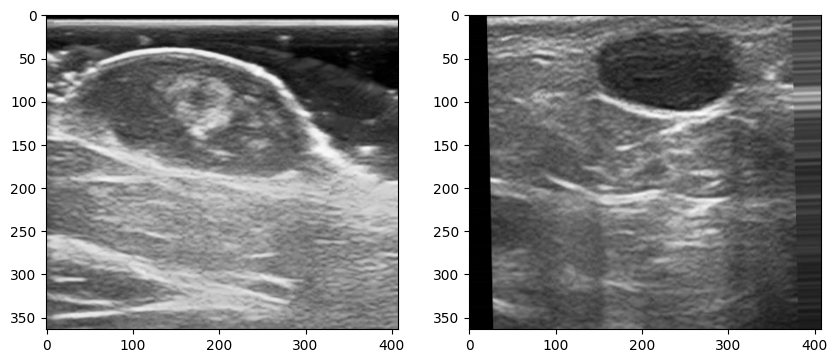

In [ ]:
imagens = []
for subdir in os.listdir(diretorio):
    subdir_path = os.path.join(diretorio, subdir)
    for arquivo in os.listdir(subdir_path):
      img = cv2.imread(subdir_path + '/' + arquivo)
      imagens.append(img)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(imagens[150])

plt.subplot(122)
plt.imshow(imagens[len(imagens)-1])

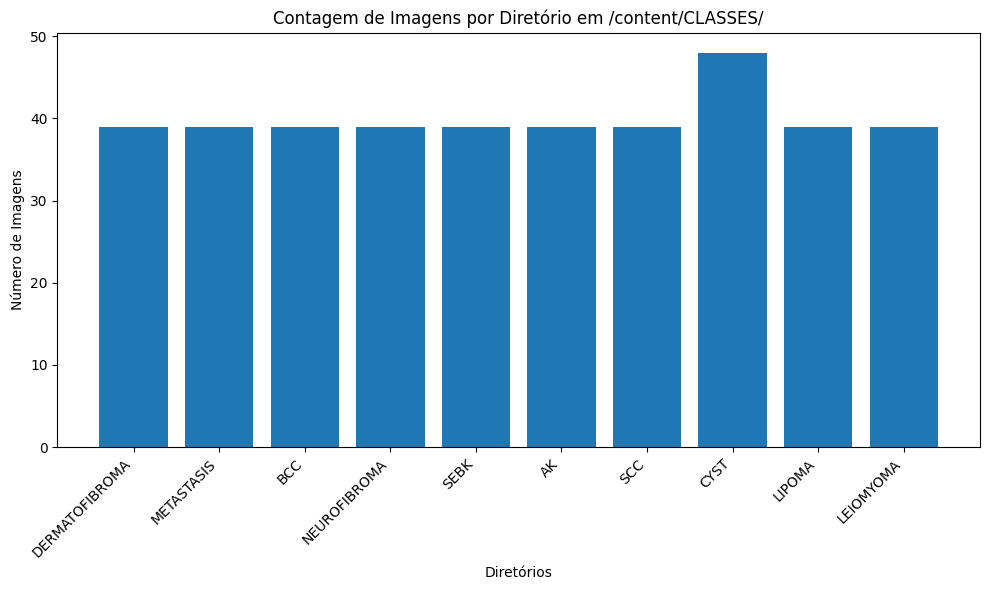

{'DERMATOFIBROMA': 39, 'METASTASIS': 39, 'BCC': 39, 'NEUROFIBROMA': 39, 'SEBK': 39, 'AK': 39, 'SCC': 39, 'CYST': 48, 'LIPOMA': 39, 'LEIOMYOMA': 39}


In [ ]:
contagens = {subdir: conta_imagens(os.path.join(diretorio, subdir))
            for subdir in os.listdir(diretorio)
            if os.path.isdir(os.path.join(diretorio, subdir))}

plt.figure(figsize=(10, 6))
plt.bar(contagens.keys(), contagens.values())
plt.xlabel('Diretórios')
plt.ylabel('Número de Imagens')
plt.title('Contagem de Imagens por Diretório em /content/CLASSES/')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(contagens)

In [ ]:
for c in contagens:
  print(c + ':', contagens[c])

DERMATOFIBROMA: 39
METASTASIS: 39
BCC: 39
NEUROFIBROMA: 39
SEBK: 39
AK: 39
SCC: 39
CYST: 48
LIPOMA: 39
LEIOMYOMA: 39


In [ ]:
diretorio = '/content/CLASSES/'

num_imagens_desejado = 39

datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

def conta_imagens(dir):
    return sum(1 for arq in os.listdir(dir) if os.path.isfile(os.path.join(dir, arq)))

for nome_classe in os.listdir(diretorio):
    caminho_classe = os.path.join(diretorio, nome_classe)
    if os.path.isdir(caminho_classe):
        contagens = {subdir: conta_imagens(os.path.join(diretorio, subdir))
                     for subdir in os.listdir(diretorio)
                     if os.path.isdir(os.path.join(diretorio, subdir))}

        if contagens[nome_classe] < 35:
            num_imagens_a_gerar = num_imagens_desejado - contagens[nome_classe]

            if num_imagens_a_gerar > 0:
                i = 0
                # Get a list of image files in the class directory
                imagens_classe = [f for f in os.listdir(caminho_classe) if os.path.isfile(os.path.join(caminho_classe, f))]

                # Loop until enough images are generated
                while i < num_imagens_a_gerar:
                    nome_arquivo = random.choice(imagens_classe)
                    caminho_imagem = os.path.join(caminho_classe, nome_arquivo)
                    imagem = cv2.imread(caminho_imagem)
                    for batch in datagen.flow(
                        x=imagem.reshape((1,) + imagem.shape),
                        batch_size=1,
                        save_to_dir=caminho_classe,
                        save_prefix='augmented_',
                        save_format='jpg'
                    ):
                        i += 1
                        break  # Exit the inner for loop after generating on

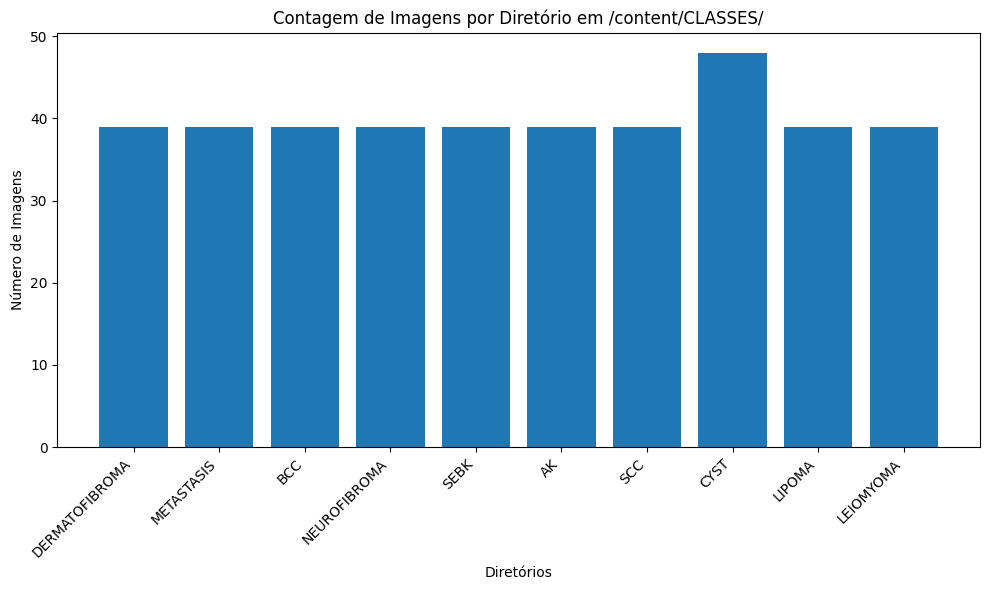

{'DERMATOFIBROMA': 39, 'METASTASIS': 39, 'BCC': 39, 'NEUROFIBROMA': 39, 'SEBK': 39, 'AK': 39, 'SCC': 39, 'CYST': 48, 'LIPOMA': 39, 'LEIOMYOMA': 39}


In [ ]:
contagens = {subdir: conta_imagens(os.path.join(diretorio, subdir))
            for subdir in os.listdir(diretorio)
            if os.path.isdir(os.path.join(diretorio, subdir))}


plt.figure(figsize=(10, 6))
plt.bar(contagens.keys(), contagens.values())
plt.xlabel('Diretórios')
plt.ylabel('Número de Imagens')
plt.title('Contagem de Imagens por Diretório em /content/CLASSES/')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(contagens)

In [ ]:
diretorio = '/content/CLASSES/'

diretorio_treino = '/content/TRAIN/'
diretorio_validacao = '/content/VAL/'
diretorio_teste = '/content/TEST/'

os.makedirs(diretorio_treino, exist_ok=True)
os.makedirs(diretorio_validacao, exist_ok=True)
os.makedirs(diretorio_teste, exist_ok=True)

# Proporções para dividir os dados
proporcao_treino = 0.7
proporcao_validacao = 0.15
proporcao_teste = 0.15

# Iterar pelas subpastas de classes
for nome_classe in os.listdir(diretorio):
    caminho_classe = os.path.join(diretorio, nome_classe)
    if os.path.isdir(caminho_classe):
        # Obter a lista de imagens na classe
        imagens_classe = os.listdir(caminho_classe)

        # Dividi as imagens em conjuntos de treinamento, validação e teste
        imagens_treino, imagens_teste = train_test_split(imagens_classe, test_size=proporcao_teste, random_state=42)
        imagens_treino, imagens_validacao = train_test_split(imagens_treino, test_size=proporcao_validacao / (proporcao_treino + proporcao_validacao), random_state=42)
        np.random.shuffle(imagens_treino)  # Embaralha as imagens para o conjunto de treino

        # Cria os subdiretórios para cada classe nos diretorios
        os.makedirs(os.path.join(diretorio_treino, nome_classe), exist_ok=True)
        os.makedirs(os.path.join(diretorio_validacao, nome_classe), exist_ok=True)
        os.makedirs(os.path.join(diretorio_teste, nome_classe), exist_ok=True)

        # Realiza a leitura das imagens, realiza resize nestas e as escreve no diretorio do conjunto com classe de destino
        for imagem in imagens_treino:
            img = cv2.imread(os.path.join(caminho_classe, imagem))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.equalizeHist(img)
            img = cv2.resize(img, (200, 200))
            cv2.imwrite(os.path.join(diretorio_treino, nome_classe, imagem), img)

        for imagem in imagens_validacao:
            img = cv2.imread(os.path.join(caminho_classe, imagem))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.equalizeHist(img)
            img = cv2.resize(img, (200, 200))
            cv2.imwrite(os.path.join(diretorio_validacao, nome_classe, imagem), img)

        for imagem in imagens_teste:
            img = cv2.imread(os.path.join(caminho_classe, imagem))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.equalizeHist(img)
            img = cv2.resize(img, (200, 200))
            cv2.imwrite(os.path.join(diretorio_teste, nome_classe, imagem), img)

(200, 200, 3)


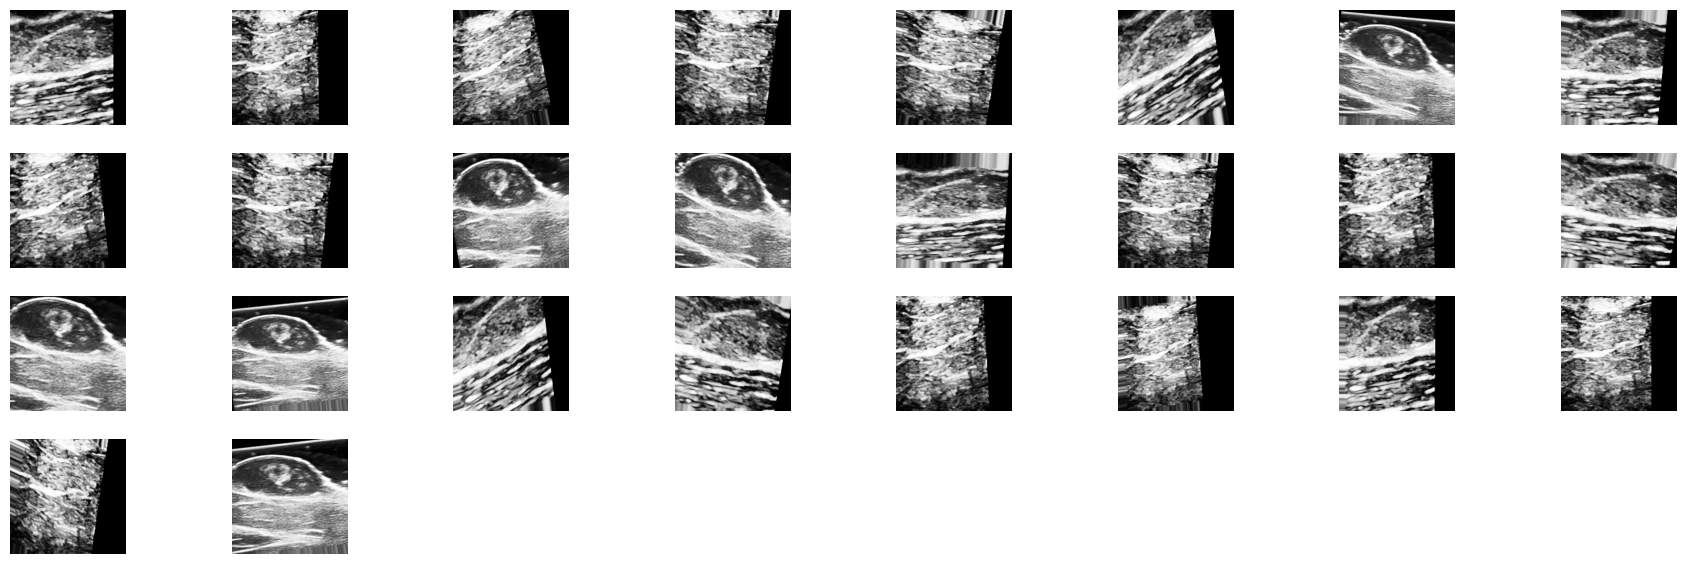

In [ ]:
image = []
dir = '/content/TRAIN/NEUROFIBROMA/'
for img in os.listdir(dir):
    image.append(cv2.imread(dir + img))
print(image[0].shape)

def show_first_10_images(img):
    plt.figure(figsize=(18, 6))
    for i in range(len(image)-1):
        plt.subplot(4, 8, i+1)
        plt.imshow(img[i], cmap='gray')
        plt.axis('off')

    plt.tight_layout(pad=2.0)
    plt.show()

show_first_10_images(image)


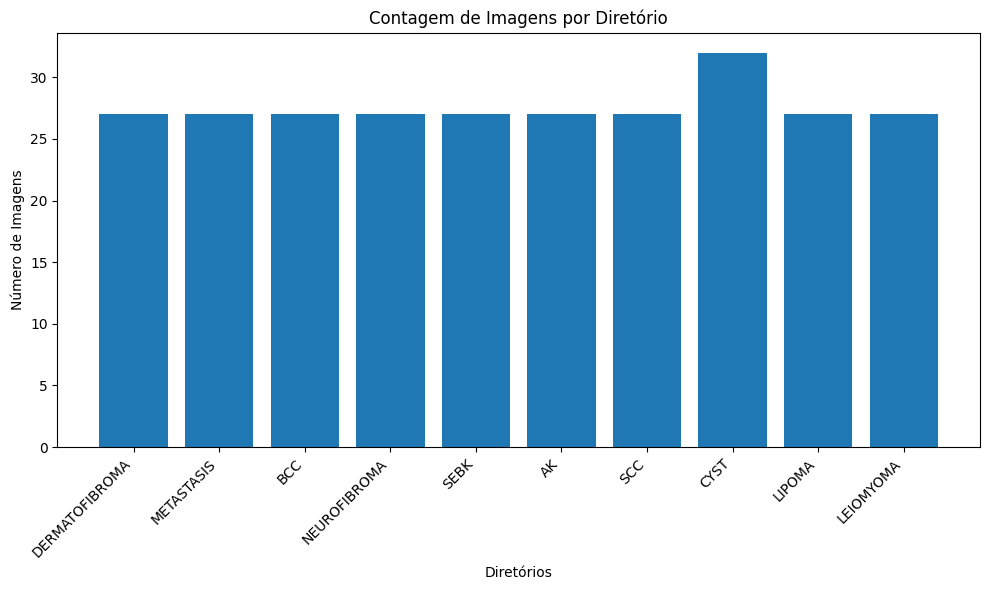

{'DERMATOFIBROMA': 27, 'METASTASIS': 27, 'BCC': 27, 'NEUROFIBROMA': 27, 'SEBK': 27, 'AK': 27, 'SCC': 27, 'CYST': 32, 'LIPOMA': 27, 'LEIOMYOMA': 27}


In [ ]:
diret = '/content/TRAIN/'
contagens = {subdir: conta_imagens(os.path.join(diret, subdir))
            for subdir in os.listdir(diret)
            if os.path.isdir(os.path.join(diret, subdir))}


plt.figure(figsize=(10, 6))
plt.bar(contagens.keys(), contagens.values())
plt.xlabel('Diretórios')
plt.ylabel('Número de Imagens')
plt.title('Contagem de Imagens por Diretório')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(contagens)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as ke
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
import seaborn as sns
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras import models
from keras import layers
from keras import optimizers

from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


init_notebook_mode(connected=True)

In [2]:
train_dir = '/content/TRAIN/'
val_dir = '/content/VAL/'
test_dir = '/content/TEST/'

categories = ['DERMATOFIBROMA', 'METASTASIS', 'BCC', 'NEUROFIBROMA', 'SEBK', 'AK', 'SCC', 'CYST', 'LIPOMA', 'LEIOMYOMA']
x_test = []
y_test = []
x_train = []
y_train = []
x_val = []
y_val = []



for dir in os.listdir(train_dir):
    if dir in categories:
       path = os.path.join(train_dir, dir)
       for image in tqdm(os.listdir(path), desc=f'Processing {dir}'):
          image = cv2.imread(os.path.join(path, image))
          x_train.append(image)
          y_train.append(categories.index(dir))

for dir in os.listdir(test_dir):
    if dir in categories:
       path = os.path.join(test_dir, dir)
       for image in tqdm(os.listdir(path), desc=f'Processing {dir}'):
          image = cv2.imread(os.path.join(path, image))
          x_test.append(image)
          y_test.append(categories.index(dir))

for dir in os.listdir(val_dir):
    if dir in categories:
       path = os.path.join(val_dir, dir)
       for image in tqdm(os.listdir(path), desc=f'Processing {dir}'):
          image = cv2.imread(os.path.join(path, image))
          x_val.append(image)
          y_val.append(categories.index(dir))

x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)


y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)
#y_train = to_categorical(y_train, num_classes=10)
#y_test = to_categorical(y_test, num_classes=10)
#y_val = to_categorical(y_val, num_classes=10)

#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
#y_val = to_categorical(y_val)

Processing LEIOMYOMA: 100%|██████████| 6/6 [00:00<00:00, 827.96it/s]


In [3]:
x_train = x_train/ 255.0
x_test = x_test/ 255.0
x_val = x_val/ 255.0

print(len(x_train),x_train.shape)
print(len(y_train))

275 (275, 200, 200, 3)
275


In [4]:
conv_base = ke.applications.VGG16(
 weights="imagenet",
 include_top=False,
 input_shape=(200, 200, 3))

for layer in conv_base.layers:
    layer.trainable = False
conv_base.summary()

In [5]:
model = ke.models.Sequential()
model.add(conv_base)
model.add(ke.layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))),
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='sigmoid', kernel_regularizer=l2(0.01))),
model.add(layers.Dropout(0.2))  # utilizando a regularização L2
model.add(layers.Dense(len(categories), activation='softmax'))

for layer in conv_base.layers[-4:]:  # Descongelando as ultimas camadas da rede convolucional
    layer.trainable = True

model.compile(optimizer='adam', # Reduced learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 6, 6, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,880,202 (56.76 MB)

 Trainable params: 7,244,938 (27.64 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

history = model.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size = 32,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping])

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 230s 25s/step - accuracy: 0.0721 - loss: 7.3849 - val_accuracy: 0.1129 - val_loss: 6.4201
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 214s 24s/step - accuracy: 0.1933 - loss: 6.2766 - val_accuracy: 0.3387 - val_loss: 5.3628
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 249s 23s/step - accuracy: 0.3049 - loss: 5.2175 - val_accuracy: 0.5000 - val_loss: 4.5023
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 210s 24s/step - accuracy: 0.4328 - loss: 4.4992 - val_accuracy: 0.4839 - val_loss: 3.8754
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 200s 22s/step - accuracy: 0.3995 - loss: 3.8718 - val_accuracy: 0.5323 - val_loss: 3.5023
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 217s 24s/step - accuracy: 0.4672 - loss: 3.4497 - val_accuracy: 0.5968 - val_loss: 3.0019
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 255s 24s/step - accuracy: 0.5380 - loss: 3.0384 - val_accuracy: 0.5968 - val_loss: 2.7070
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 252s 22s/step - accuracy: 0.7032 - loss: 2.5008 - val_accuracy: 0.7097 - val_loss:

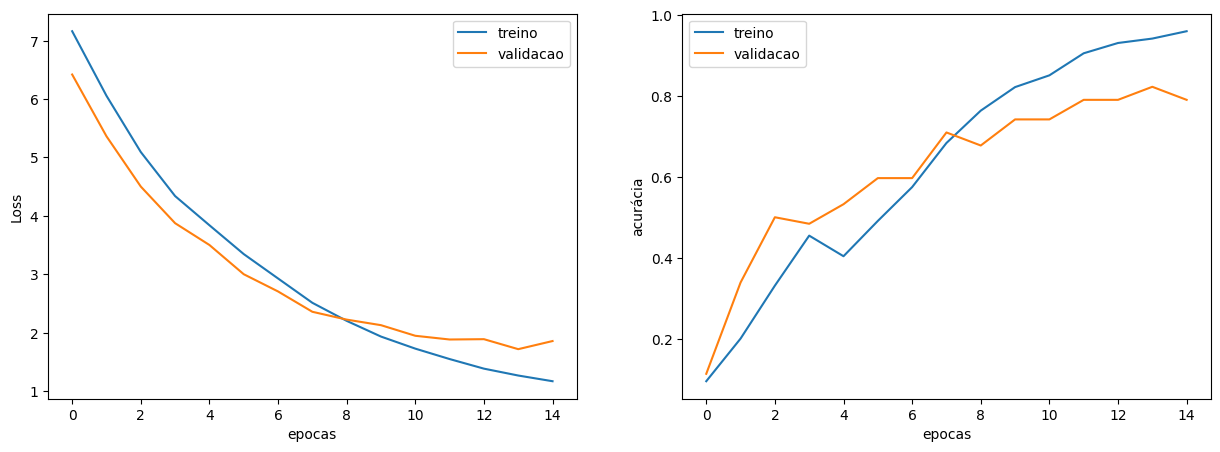

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="treino")
plt.plot(history.history["val_loss"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("Loss")
plt.legend();
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="treino")
plt.plot(history.history["val_accuracy"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("acurácia")
plt.legend();

2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 15s/step


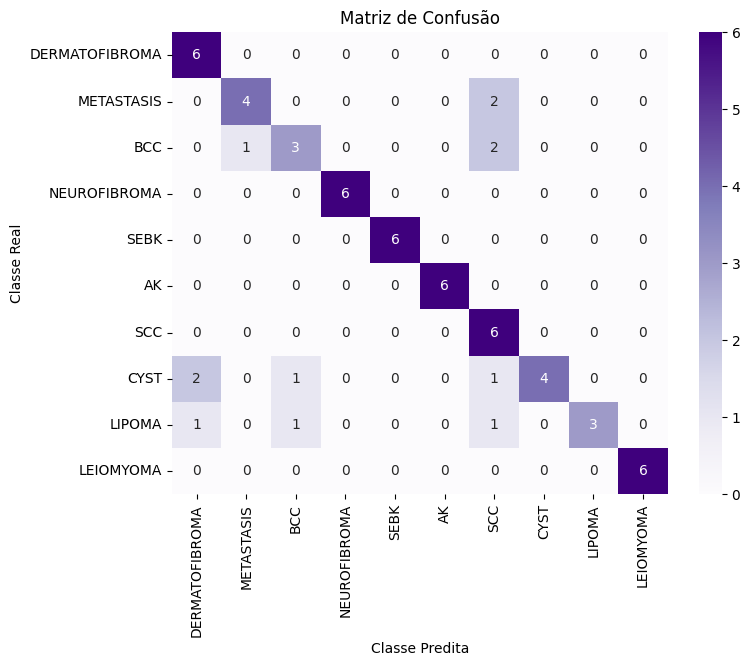

In [8]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# matriz de confusão
cm = confusion_matrix(y_test, y_pred)
#print(cm)

# Rótulos das classes
classes = categories

# Plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()
